In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
# from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
# from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
# from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [5]:
#Creating db file from csv    #265SEC
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [6]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [7]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [8]:
# try to sample data according to the computing power you have   #112Mins
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [9]:
# remove the first row to round off number of rows
data.drop(data.index[0], inplace=True)
data=data.dropna()
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [12]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model

for i in data.columns:
    # print(i)
    data[i] = data[i].apply(pd.to_numeric)
    # print(i)

In [13]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".0f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Number of data points in train data : (69996, 218)
Number of data points in test data : (29999, 218)
---------- Distribution of output variable in train data ----------
Class 0:  0.630221726955826 Class 1:  0.36977827304417393
---------- Distribution of output variable in test data ----------
Class 0:  0.6302210073669122 Class 1:  0.3697789926330878


<h3> Building a random model (Finding worst-case log-loss)</h3>

Log loss on Test Data using Random Model 0.87958358381974


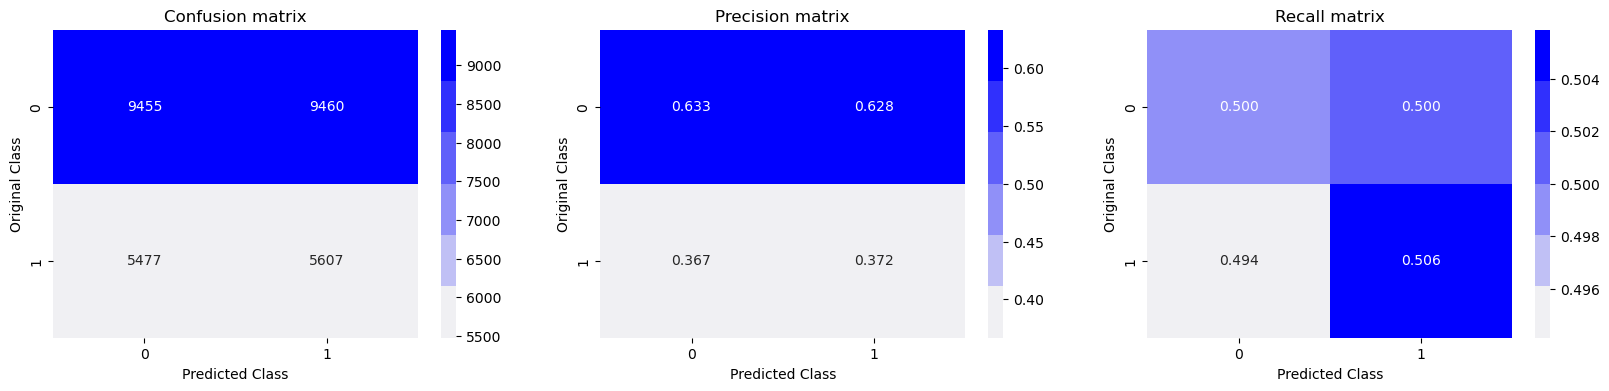

In [42]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
from sklearn.metrics import accuracy_score, log_loss
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h3> Logistic Regression with hyperparameter tuning </h3>

In [48]:
print(X_train.shape)
print(len(y_train))

(69995, 218)
69995


For values of alpha =  1e-05 The log loss is: 0.43370386272040173
For values of alpha =  0.0001 The log loss is: 0.4355264859302301
For values of alpha =  0.001 The log loss is: 0.444075781417806
For values of alpha =  0.01 The log loss is: 0.41971207242688274
For values of alpha =  0.1 The log loss is: 0.438014937085211
For values of alpha =  1 The log loss is: 0.47258980249658533
For values of alpha =  10 The log loss is: 0.5152603923620586


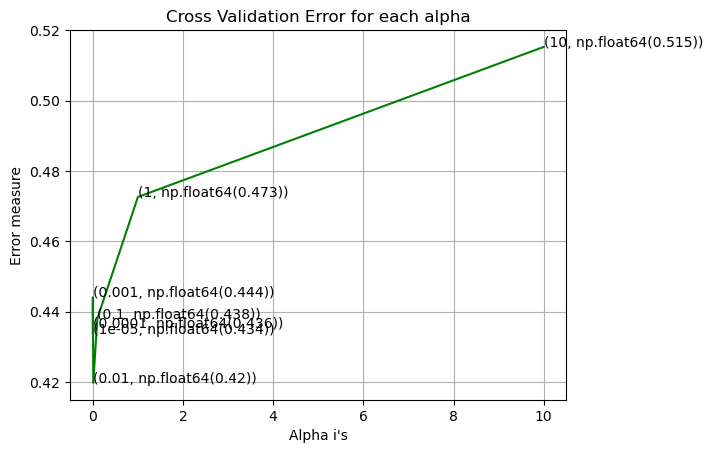

For values of best alpha =  0.01 The train log loss is: 0.42061612864864234
For values of best alpha =  0.01 The test log loss is: 0.41971207242688274
Total number of data points : 29999


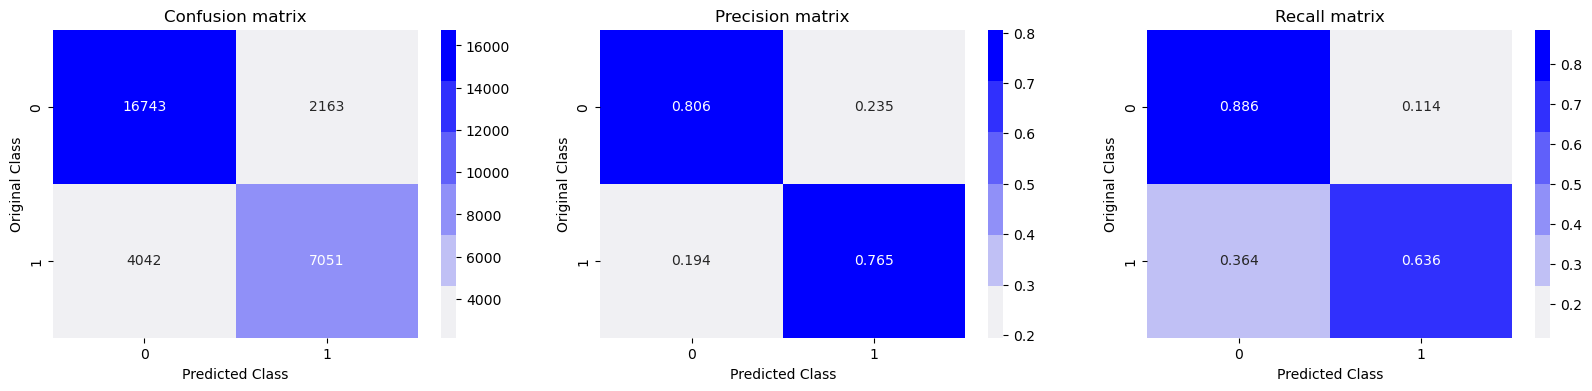

In [15]:
from sklearn.metrics import accuracy_score, log_loss
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------
# Count the number of rows with at least one NaN value
X_train = X_train.dropna()
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h3> Linear SVM with hyperparameter tuning </h3>

For values of alpha =  1e-05 The log loss is: 0.4298667501174899
For values of alpha =  0.0001 The log loss is: 0.4447175084389908
For values of alpha =  0.001 The log loss is: 0.501683761367594
For values of alpha =  0.01 The log loss is: 0.5031384338643725
For values of alpha =  0.1 The log loss is: 0.5389397277630644
For values of alpha =  1 The log loss is: 0.621124837386646
For values of alpha =  10 The log loss is: 0.6128340917941565


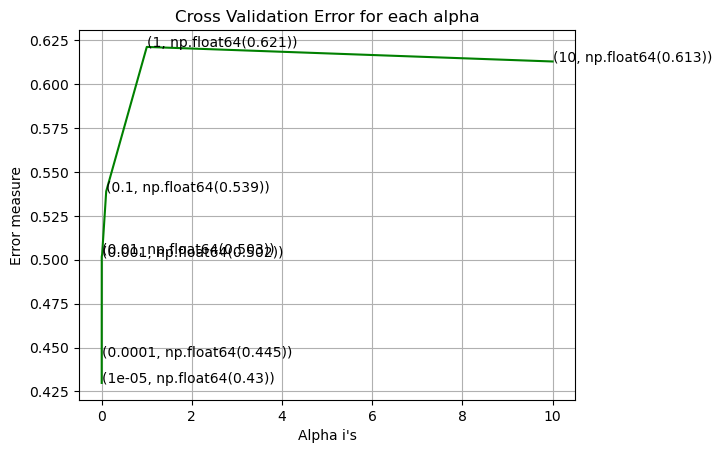

For values of best alpha =  1e-05 The train log loss is: 0.43170516938015396
For values of best alpha =  1e-05 The test log loss is: 0.4298667501174899
Total number of data points : 29999


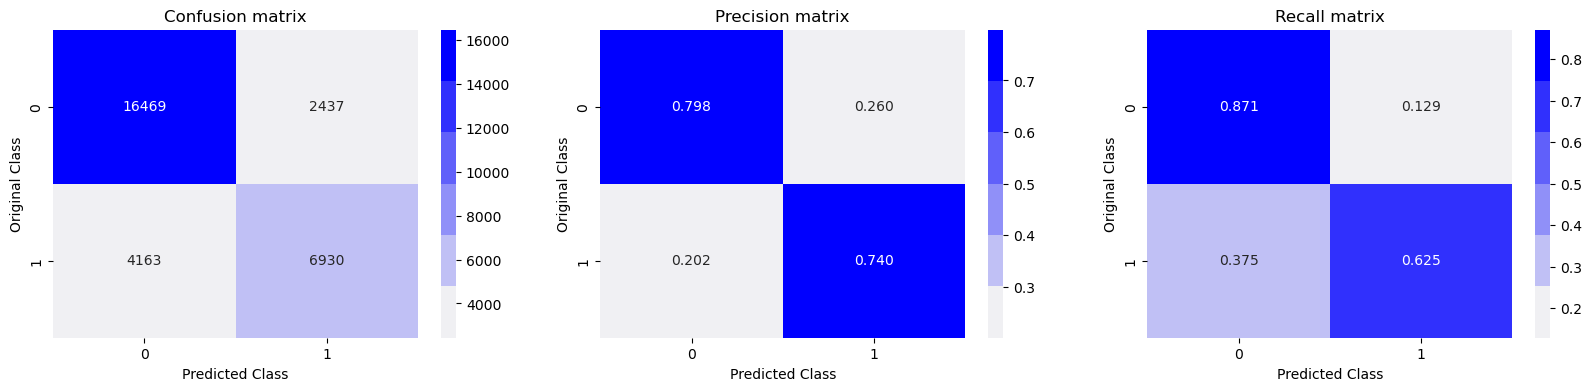

In [17]:
from sklearn.metrics import accuracy_score, log_loss
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [19]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

[0]	train-logloss:0.65149	valid-logloss:0.65146
[10]	train-logloss:0.58832	valid-logloss:0.58779
[20]	train-logloss:0.54320	valid-logloss:0.54238
[30]	train-logloss:0.50900	valid-logloss:0.50807
[40]	train-logloss:0.48290	valid-logloss:0.48187
[50]	train-logloss:0.46248	valid-logloss:0.46139
[60]	train-logloss:0.44652	valid-logloss:0.44544
[70]	train-logloss:0.43373	valid-logloss:0.43269
[80]	train-logloss:0.42317	valid-logloss:0.42219
[90]	train-logloss:0.41450	valid-logloss:0.41356
[100]	train-logloss:0.40717	valid-logloss:0.40620
[110]	train-logloss:0.40105	valid-logloss:0.40013
[120]	train-logloss:0.39576	valid-logloss:0.39490
[130]	train-logloss:0.39138	valid-logloss:0.39057
[140]	train-logloss:0.38758	valid-logloss:0.38686
[150]	train-logloss:0.38437	valid-logloss:0.38377
[160]	train-logloss:0.38145	valid-logloss:0.38103
[170]	train-logloss:0.37894	valid-logloss:0.37872
[180]	train-logloss:0.37672	valid-logloss:0.37667
[190]	train-logloss:0.37475	valid-logloss:0.37490
[200]	train

Total number of data points : 29999


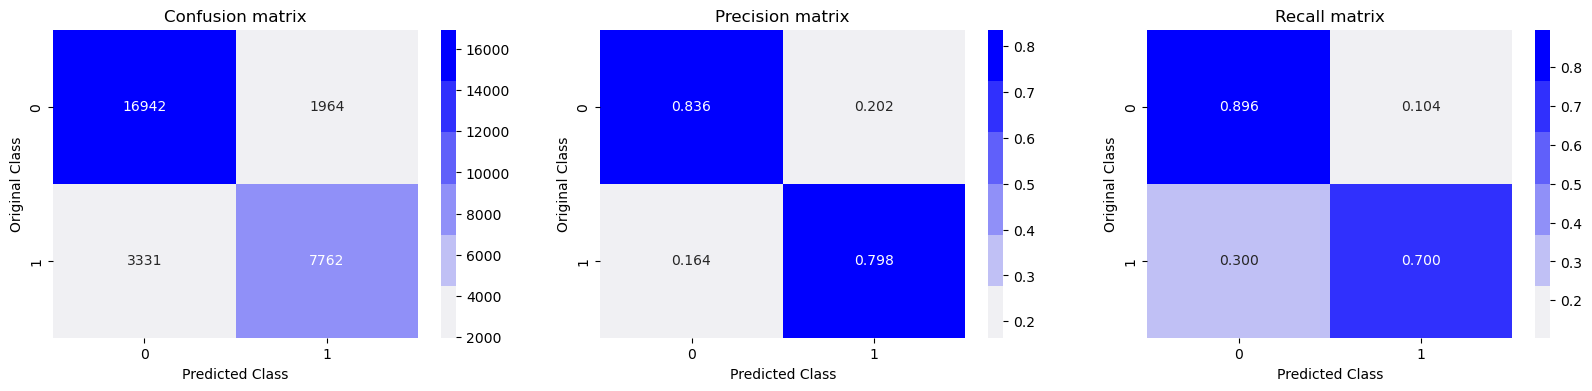

In [20]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss